# Final Project
## EX 3: Object detection with linear models
In this exercise we develop a linear model for object detection in images.
Specifically, we will train the model to detect the area of an image in which a
hand is shown to gesture a sign language sign.

We will develop a linear model that, given an image $x$ (an array of pixels),
produces a bounding box $y$. The bounding box is a rectangle defined by its topleft
and bottom-right corners. Hence:
$$
y=(y_1, y_2, y_3, y_4)
$$
The detected object -- a
hand gesturing a sign -- is to be inside this bounding box.

In [1]:
import urllib.request
import os
import zipfile
import scipy
import numpy as np
import pandas as pd
from os.path import splitext

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.color import rgb2gray
import matplotlib.patches as patches
from PIL import Image
import statsmodels.stats.api as sms
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split

## Download & Unzip Data

In [2]:
url = 'https://github.com/yoavram/Sign-Language/raw/master/Dataset.zip'
filename = '../data/sign-lang'
if not os.path.exists('../data'):
    os.mkdir('../data')
if not os.path.exists(filename):
    urllib.request.urlretrieve(url, filename)

After extracting the zip file to the folder data/sign-lang, we have 7 folders, one for each person (user). Each folder has 10 images of that person gesturing one of 24 signs: the ABC letters, not including J and Z.

In [3]:
# Opening the Zip:
zf = zipfile.ZipFile(filename)

# Printing the contest of the ZIP:
# for f in data_zip.filelist: 
#     print(f.filename)

We open the csv files:

In [4]:
# example for csv filename: Dataset/user_10/user_10_loc.csv
user = 'user_10/user_10'
path = 'Dataset/{}_loc.csv'
path = path.format(user)
with zf.open(path) as f:
    df = pd.read_csv(f)
df.head()

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_10/A0.jpg,186,84,286,184
1,user_10/A1.jpg,186,84,286,184
2,user_10/A2.jpg,185,90,285,190
3,user_10/A3.jpg,180,88,290,198
4,user_10/A4.jpg,173,102,293,222


This table has 5 columns. The first column **image** provides the name of the image. The other columns provide the **bounding box** y for that image.

### Goal:
- We want to collect all images into an array X and all bounding boxes into an array Y.
- Then, we want to train a model that, given an example image x produces the bounding box y for that image, such that the bounding box will contain a gesturing hand.

#### First, we **train a generalized linear model** on a training set:

In [5]:
y = list()

for file in zf.namelist():
    basename,extension = splitext(file)
    if extension == '.csv':
        y.append(pd.read_csv(zf.open(file), index_col=None, header=0))
        
y_ = pd.concat(y)
y_.head()

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y
0,user_10/A0.jpg,186,84,286,184
1,user_10/A1.jpg,186,84,286,184
2,user_10/A2.jpg,185,90,285,190
3,user_10/A3.jpg,180,88,290,198
4,user_10/A4.jpg,173,102,293,222


In [6]:
x = []

for file in y_['image'].values:
    path = f"Dataset/{file}"
    basename,extension = splitext(path)
    if extension == '.jpg':
        pic = plt.imread(zf.open(path))
        temp = np.array(rgb2gray(pic).flatten())
        x.append(temp)
        
x = np.array(x)
print(x.shape)

(1680, 76800)


In [7]:
y = y_[['top_left_x', 'top_left_y', 'bottom_right_x', 'bottom_right_y']].values

In [8]:
stratify = y_['image'].str.split('/', expand=True)[1]
stratify.head()

0    A0.jpg
1    A1.jpg
2    A2.jpg
3    A3.jpg
4    A4.jpg
Name: 1, dtype: object

In [9]:
train_size = 0.67
X_train, X_test, Y_train, Y_test = train_test_split(x,y, stratify=stratify, test_size=(1-train_size), train_size=train_size)

In [10]:
model = RidgeCV(cv=10)
cf = model.fit(X_train, Y_train)

In [11]:
pred = cf.predict(X_test).astype(int)
pred[:10]

array([[195,  52, 318, 175],
       [134,   5, 286, 157],
       [168,  90, 241, 163],
       [142,  21, 235, 114],
       [133,  38, 288, 193],
       [156,  88, 286, 218],
       [143,  90, 252, 199],
       [ 99,  15, 217, 134],
       [179,  86, 288, 194],
       [170,  68, 280, 179]])

#### Second, we **visualize the model performance** by plotting the image, the original bounding box, and the predicted bounding box:

In [12]:
def intersection_over_union(bboxes1, bboxes2):
    x11, y11, x12, y12 = np.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(bboxes2, 4, axis=1)
    
    xA = np.maximum(x11, x21)
    yA = np.maximum(y11, y21)
    xB = np.minimum(x12, x22)
    yB = np.minimum(y12, y22)
    
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    
    iou = interArea / (boxAArea + boxBArea - interArea)
    return iou

In [13]:
def arr_to_rect(arr):
    return (arr[0], arr[1]), arr[2] - arr[0], arr[3] - arr[1]

In [14]:
def plot_bounding_box(img, true_bbox, pred_bbox):
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img.reshape(240, -1))
    
    t_left, t_width, t_height = arr_to_rect(true_bbox)
    p_left, p_width, p_height = arr_to_rect(pred_bbox)

    t_rect = patches.Rectangle(t_left, t_width, t_height,linewidth=1,edgecolor='r',facecolor='none')
    p_rect = patches.Rectangle(p_left, p_width, p_height,linewidth=1,edgecolor='b',facecolor='none')


    # Add the patch to the Axes
    ax.add_patch(t_rect)
    ax.add_patch(p_rect)
    
    plt.title(f"IoU:{intersection_over_union(np.array([true_bbox]), np.array([pred_bbox])).squeeze()}")

    plt.show()

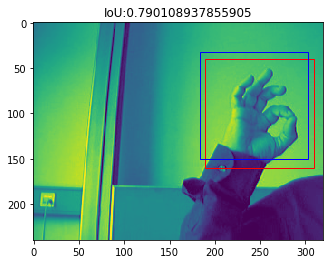

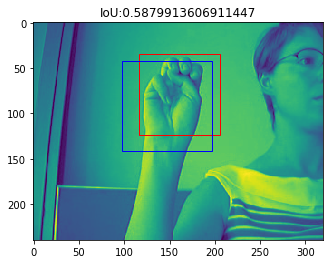

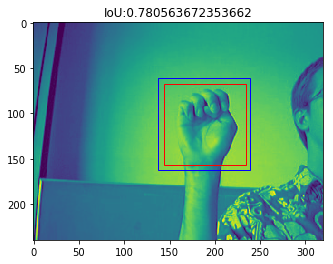

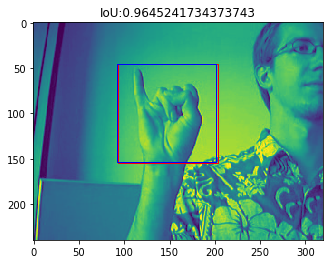

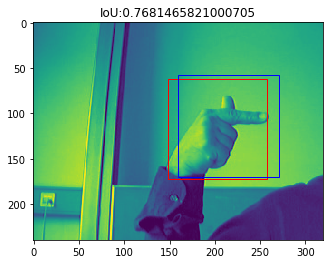

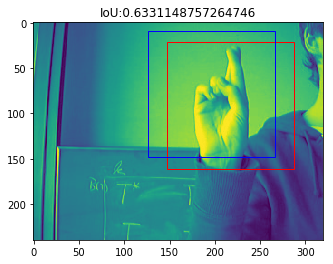

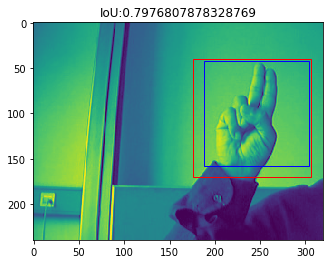

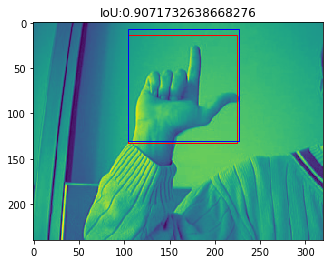

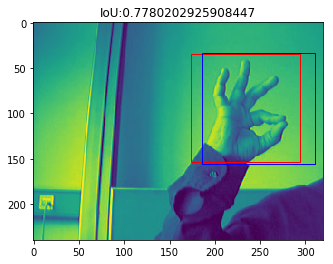

In [15]:
for index in  np.random.randint(0, X_test.shape[0], 9):
    plot_bounding_box(X_test[index], Y_test[index], pred[index])

#### Third, we **summarize model performance** by computing the IoU over all test images, plotting the IoU histogram, together with the mean and 95% confidence intervals.

Mean: 0.7773315095670604
95% Confidence Interval (0.7684237748628682, 0.7862392442712527)


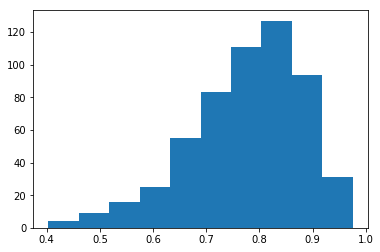

In [16]:
ious = intersection_over_union(Y_test, pred)
plt.hist(ious)
print(f"Mean: {ious.mean()}")
left, right = sms.DescrStatsW(ious).tconfint_mean()
print(f"95% Confidence Interval ({left.squeeze()}, {right.squeeze()})")